In [1]:
import pandas as pd
from PyEMD import EMD, Visualisation
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import metrics
from imblearn.combine import SMOTETomek

In [2]:
input_file = 'clean_data.parquet'
MicSigV1 = pd.read_parquet(input_file)

In [3]:
#Cleanning data
ind = np.where( MicSigV1['Type'] == '''['REGIONAL']''')
ind2 = np.where( MicSigV1['Type'] == '''['LP']''')
ind3 = np.where( MicSigV1['Type'] == '''VT ''')
MicSigV1['Type'].loc[ind[0]]  = "REGIONAL"
MicSigV1['Type'].loc[ind2[0]] = "LP"
MicSigV1['Type'].loc[ind3[0]] = "VT"

label_encoder = LabelEncoder()
MicSigV1['Type']=MicSigV1['Type'].astype('str')
MicSigV1['Type_CatNbr'] = label_encoder.fit_transform((MicSigV1['Type'].values))
y=MicSigV1['Type_CatNbr']
Type_Mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
Key_List=[key for key in Type_Mapping.keys()]

/var/folders/wm/w1v3lbn16xq6stmcqydc0ljr0000gn/T/ipykernel_85409/2007054594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MicSigV1['Type'].loc[ind[0]]  = "REGIONAL"
/var/folders/wm/w1v3lbn16xq6stmcqydc0ljr0000gn/T/ipykernel_85409/2007054594.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MicSigV1['Type'].loc[ind2[0]] = "LP"
/var/folders/wm/w1v3lbn16xq6stmcqydc0ljr0000gn/T/ipykernel_85409/2007054594.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [4]:
# Classification Model - Normalized Raw Data
# Split the data
X=MicSigV1[['E_Raw','D1_Max_Raw','Freq_Raw']]
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

In [5]:
#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn = no_neighbors[np.argmax(accuracy_knn)]

/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


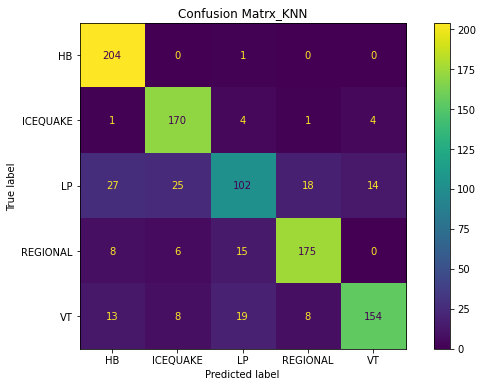

/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecate

array([[136,  47,   3,  13,   6],
       [ 23, 131,  14,   0,  12],
       [ 47,  48,  52,  24,  15],
       [ 56,   5,  21, 114,   8],
       [ 48,  48,  32,  36,  38]])

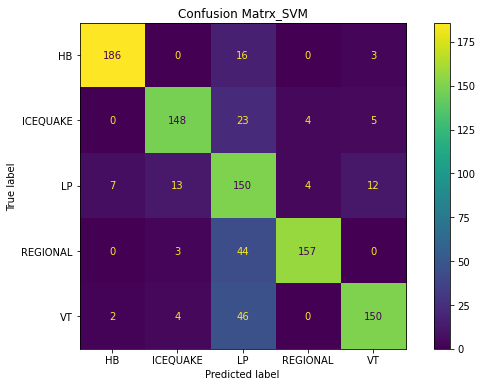

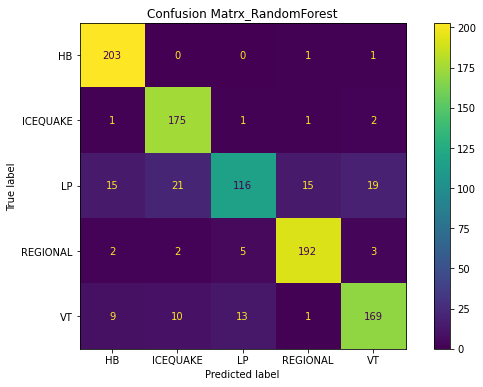

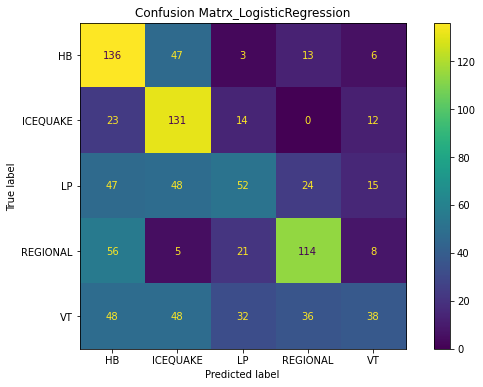

In [6]:
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix

In [7]:
#Cleanning data
ind = np.where( MicSigV1['Type'] == '''['REGIONAL']''')
ind2 = np.where( MicSigV1['Type'] == '''['LP']''')
ind3 = np.where( MicSigV1['Type'] == '''VT ''')
MicSigV1['Type'].loc[ind[0]]  = "REGIONAL"
MicSigV1['Type'].loc[ind2[0]] = "LP"
MicSigV1['Type'].loc[ind3[0]] = "VT"

label_encoder = LabelEncoder()
MicSigV1['Type']=MicSigV1['Type'].astype('str')
MicSigV1['Type_CatNbr'] = label_encoder.fit_transform((MicSigV1['Type'].values))
y=MicSigV1['Type_CatNbr']
Type_Mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
Key_List=[key for key in Type_Mapping.keys()]

/var/folders/wm/w1v3lbn16xq6stmcqydc0ljr0000gn/T/ipykernel_85409/2007054594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MicSigV1['Type'].loc[ind[0]]  = "REGIONAL"
/var/folders/wm/w1v3lbn16xq6stmcqydc0ljr0000gn/T/ipykernel_85409/2007054594.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MicSigV1['Type'].loc[ind2[0]] = "LP"
/var/folders/wm/w1v3lbn16xq6stmcqydc0ljr0000gn/T/ipykernel_85409/2007054594.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


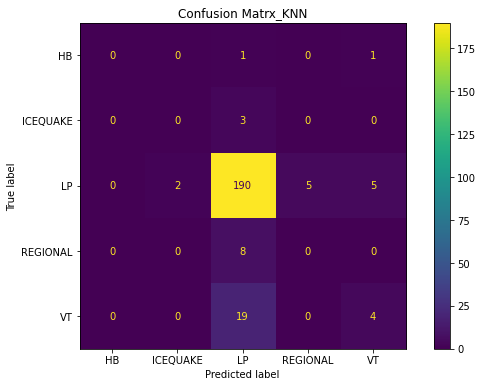

/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

array([[  0,   0,   2,   0,   0],
       [  0,   0,   3,   0,   0],
       [  0,   0, 202,   0,   0],
       [  0,   0,   7,   1,   0],
       [  0,   0,  23,   0,   0]])

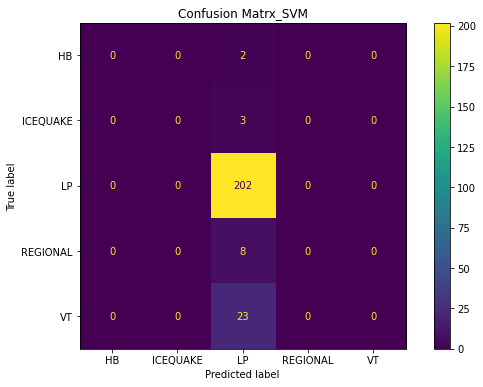

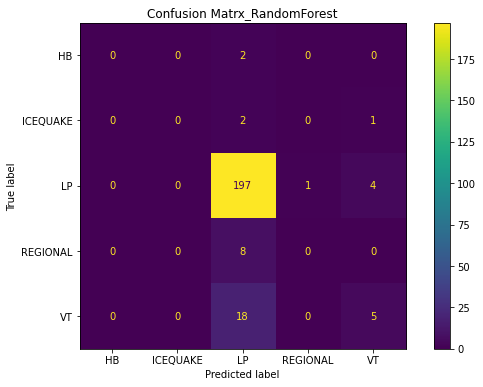

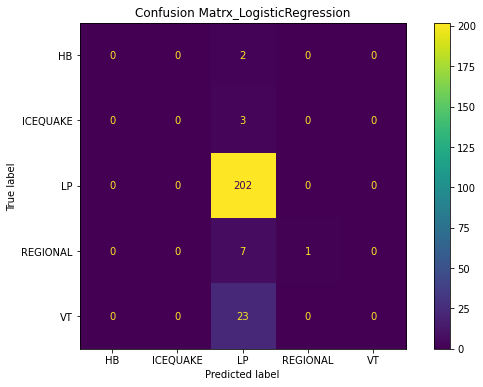

In [8]:
# Classification Model - Normalized CIIT 2
# Split the data
X=MicSigV1[['E_2','D1_Max_2','Freq_2']]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn= np.where(accuracy_knn == max(accuracy_knn))[0][0]
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
#accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix


In [9]:
#acc of Normalized CIIT 2
print("Acc-KNN", round(accuracy_score(y_test,optyts_knnpred)*100,2),"%")
print("Acc-SVM",round(accuracy_score(y_test,yts_svm )*100,2),"%")
print("Acc-RF",round(accuracy_score(y_test,yts_rf )*100,2),"%")
print("Acc-Kmeans",round(accuracy_score(y,km_model )*100,2),"%")
print("Acc-LR",round(accuracy_score(y_test,yts_lr )*100,2),"%")

Acc-KNN 84.87 %
Acc-SVM 84.87 %
Acc-RF 84.87 %
Acc-Kmeans 42.71 %
Acc-LR 85.29 %


/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


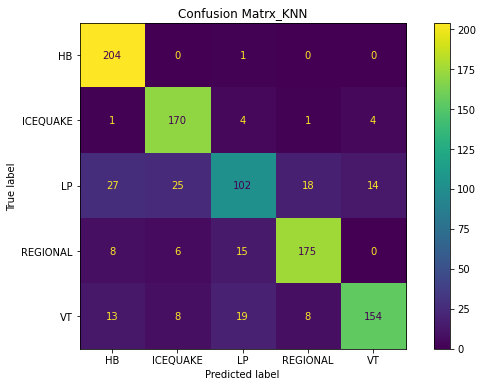

/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecate

array([[136,  47,   3,  13,   6],
       [ 23, 131,  14,   0,  12],
       [ 47,  48,  52,  24,  15],
       [ 56,   5,  21, 114,   8],
       [ 48,  48,  32,  36,  38]])

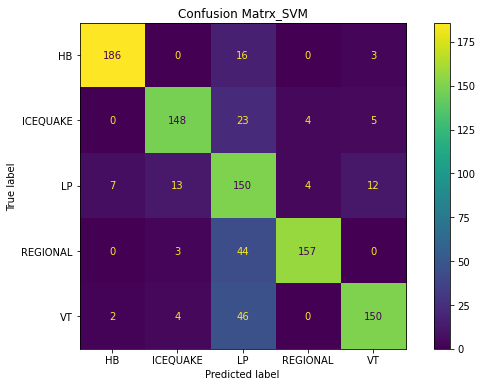

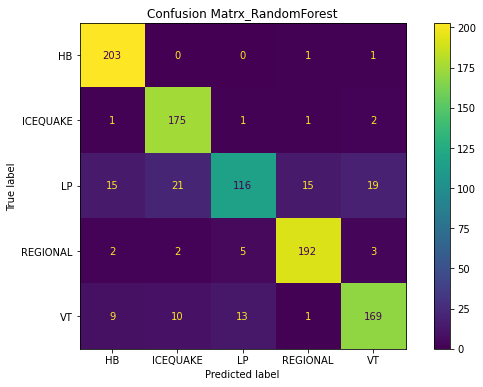

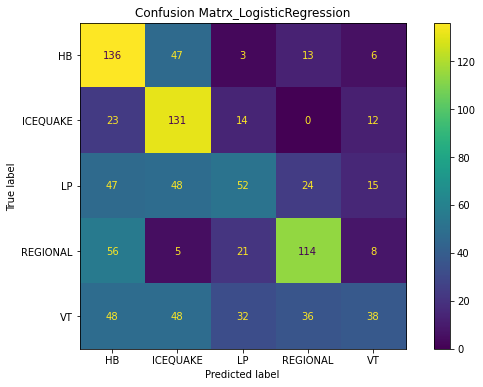

In [10]:
# Classification Model - Normalized CIIT 4
# Split the data
X=MicSigV1[['E_4','D1_Max_4','Freq_4']]
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,test_size=0.2, random_state=0)

#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn= no_neighbors[np.argmax(accuracy_knn)]
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix


In [11]:
#acc of Normalized CIIT 4
print("Acc-KNN", round(accuracy_score(y_test,optyts_knnpred)*100,2),"%")
print("Acc-SVM",round(accuracy_score(y_test,yts_svm )*100,2),"%")
print("Acc-RF",round(accuracy_score(y_test,yts_rf )*100,2),"%")
print("Acc-Kmeans",round(accuracy_score(y,km_model )*100,2),"%")
print("Acc-LR",round(accuracy_score(y_test,yts_lr )*100,2),"%")

Acc-KNN 60.18 %
Acc-SVM 80.96 %
Acc-RF 87.51 %
Acc-Kmeans 38.33 %
Acc-LR 48.21 %


/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


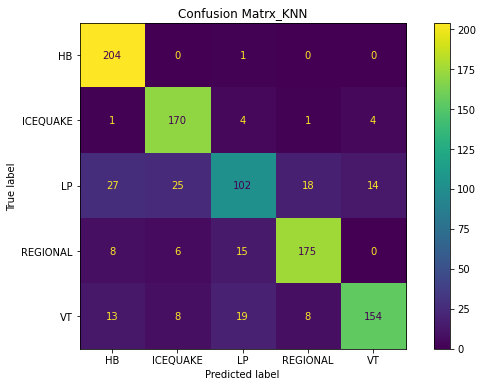

/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/dva-proj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecate

array([[136,  47,   3,  13,   6],
       [ 23, 131,  14,   0,  12],
       [ 47,  48,  52,  24,  15],
       [ 56,   5,  21, 114,   8],
       [ 48,  48,  32,  36,  38]])

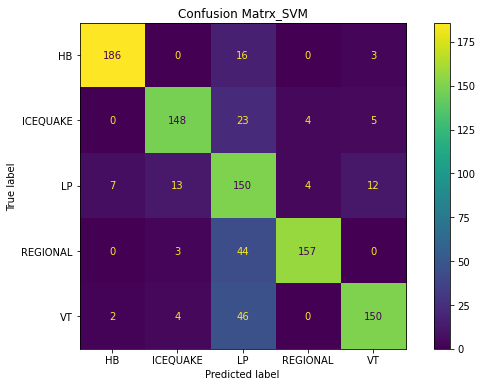

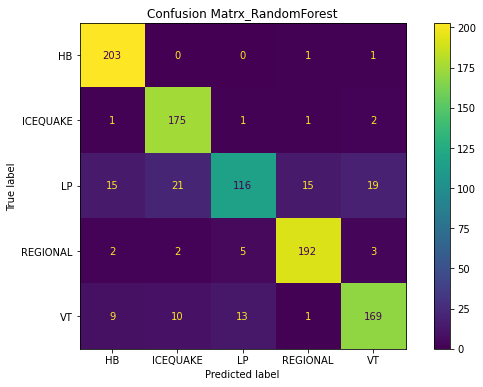

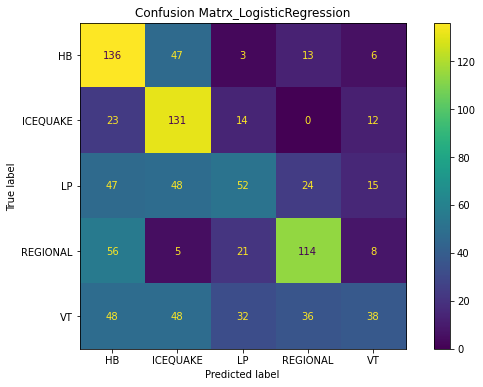

In [12]:
# Classification Model - Normalized CIIT 6
# Split the data
X=MicSigV1[['E_6','D1_Max_6','Freq_6']]
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,test_size=0.2, random_state=0)

#Knn Model
no_neighbors = np.arange(2,50,5)
accuracy_knn = np.zeros((no_neighbors.shape[0]))
k=0
for knn in no_neighbors:
    knn_model= KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
    yts_knnpred= knn_model.predict(X_test) #confusion_matrix(y_train, y_pred)
    accuracy_knn[k]=accuracy_score(y_test, yts_knnpred)
    k += 1
opt_knn= no_neighbors[np.argmax(accuracy_knn)]
optknn_model= KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
optyts_knnpred= knn_model.predict(X_test) 
confusion_matrix(y_test,optyts_knnpred )
#accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_KNN')
disp =metrics.plot_confusion_matrix(optknn_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp.confusion_matrix
plt.show()

#SVM for multiclasses
svm_model=SVC(gamma='auto',decision_function_shape='ovo').fit(X_train, y_train)
yts_svm=svm_model.predict(X_test) 
confusion_matrix(y_test,yts_svm ) 
#accuracy_score(y_test,yts_svm ) #0.8487394957983193
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_SVM')
disp2 =metrics.plot_confusion_matrix(svm_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp2.confusion_matrix

#random forest
rf_model=RandomForestClassifier(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
yts_rf=rf_model.predict(X_test)
confusion_matrix(y_test,yts_rf )
accuracy_score(y_test,yts_rf ) #0.8613445378151261
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_RandomForest')
disp3 =metrics.plot_confusion_matrix(rf_model, X_test, y_test, display_labels= Key_List, ax = ax)
disp3.confusion_matrix

#Kmeans 
km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
confusion_matrix(y,km_model )
accuracy_score(y,km_model )  #0.2384161752316765

#sc = preprocessing.StandardScaler()
#scaler = sc.fit_transform(X_train)
lr = linear_model.LogisticRegression(multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
yts_lr=lr.predict(X_test)
accuracy_score(y_test,yts_lr ) #0.8529411764705882
confusion_matrix(y_test,yts_lr )
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx_LogisticRegression')
disp4 =metrics.plot_confusion_matrix(lr, X_test, y_test, display_labels= Key_List, ax = ax)
disp4.confusion_matrix


In [13]:
#acc of Normalized CIIT 6
print("Acc-KNN", round(accuracy_score(y_test,optyts_knnpred)*100,2),"%")
print("Acc-SVM",round(accuracy_score(y_test,yts_svm )*100,2),"%")
print("Acc-RF",round(accuracy_score(y_test,yts_rf )*100,2),"%")
print("Acc-Kmeans",round(accuracy_score(y,km_model )*100,2),"%")
print("Acc-LR",round(accuracy_score(y_test,yts_lr )*100,2),"%")

Acc-KNN 60.18 %
Acc-SVM 80.96 %
Acc-RF 87.51 %
Acc-Kmeans 2.53 %
Acc-LR 48.21 %
